# CUSTOMER SEGEMENTATION USING DECISION TREES

_**Predicting a segment that a customer could belong to based on demographic information, spending habits and other parameters.**_

In [2]:
# Imports required packages

import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


## Data Collection

In [4]:
# Loads dataset from csv file
train_dataset = pd.read_csv("../Data/customer_segmentation/Train.csv")
test_dataset = pd.read_csv("../Data/customer_segmentation/Test.csv")

In [5]:
# Displays train data samples
display(train_dataset.head())

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [6]:
# Displays test data samples
display(test_dataset.head())

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


## Exploratory Data Analysis (EDA)

In [8]:
# Checks for basic information about the dataset

train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [9]:
# Checks for the descriptive statistics of the dataset
train_dataset.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


**Observations from the basic information are**
- Most features are non-numeric
- Most features have missing values

In [11]:
# Checks for attributes having missing values in train dataset
train_dataset.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

As total number (by summing up non-zeros above) of training instances having missing value is significant with respect to total training instances, removing them may not make sense.

**Checks for the values in each categorical attribute**

In [14]:
train_dataset.Gender.value_counts()

Gender
Male      4417
Female    3651
Name: count, dtype: int64

In [15]:
train_dataset.Ever_Married.value_counts()

Ever_Married
Yes    4643
No     3285
Name: count, dtype: int64

In [16]:
train_dataset.Graduated.value_counts()

Graduated
Yes    4968
No     3022
Name: count, dtype: int64

In [17]:
train_dataset.Profession.value_counts()

Profession
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
Name: count, dtype: int64

In [18]:
train_dataset.Spending_Score.value_counts()

Spending_Score
Low        4878
Average    1974
High       1216
Name: count, dtype: int64

In [19]:
train_dataset.Var_1.value_counts()

Var_1
Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: count, dtype: int64

In [20]:
train_dataset.Segmentation.value_counts()

Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64

## Data Preparation

### Checking for Duplicate Instances

In [23]:
# Drops duplicate instances, if any
train_dataset.drop_duplicates(keep='first', inplace=True)

### Removing Non-required Attributes

In [25]:
# Drops 'ID' attributes from both train and test dataset

X_train = train_dataset.drop(["ID"], axis=1)
X_test = test_dataset.drop(["ID"], axis=1)

### Setting-up Pipeline for Data Transformation

In [27]:
# Stores name of the categorical and numeric attributes

categorical_columns = ['Gender', 'Ever_Married', 'Graduated','Profession', 'Spending_Score']
numerical_columns = ['Age', 'Work_Experience', 'Family_Size']

In [28]:
# Sets up pipeline for categorical attributes

categorical_pipeline = Pipeline([
    # To impute missing values with most frequent value for each categorical attribute
    ("imputer", SimpleImputer(strategy="most_frequent")),
    
    # And then encodes the categorical attribute if disticts value count of that attribute is more than 2
    ("encoder", OneHotEncoder(sparse_output=False, min_frequency=3))
])

In [29]:
# Sets up column transfomer for both categorial and numerical attributes

column_transformer = ColumnTransformer([
    # To call categorical pipeline for categorical attribute
    ("categorical_pipeline", categorical_pipeline, categorical_columns),
    
    # To impute missing values with numerical attribute's median value
    ("numerical_imputer", SimpleImputer(strategy="median"), numerical_columns),
])

In [30]:
# Separates target from the train dataset

y_train = X_train.Segmentation.copy()
X_train.drop(["Segmentation"], axis=1, inplace=True)

## Modeling

In [32]:
# Sets up final pipeline for modeling

model_pipeline = Pipeline([
    ("data_transformation", column_transformer),
    ("modeling", DecisionTreeClassifier(criterion="entropy", max_depth = 5, random_state=42))
])

In [33]:
# Performs model training and predictions over cross validation
y_train_predictions = cross_val_predict(model_pipeline, X_train, y_train, cv=10, n_jobs=-1)

In [34]:
# Checks for accuracy over cross validation
print("Cross Validation Accuracy: {:.2%}".format(accuracy_score(y_train, y_train_predictions)))

Cross Validation Accuracy: 52.22%


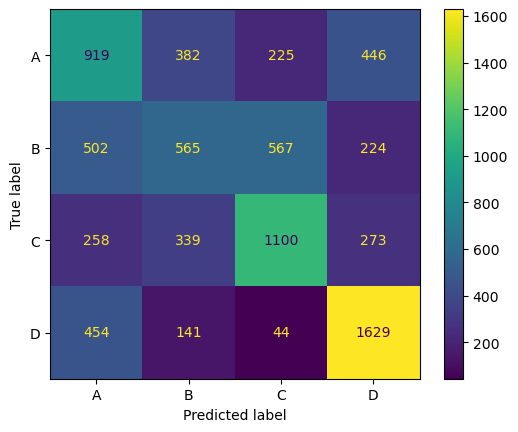

In [35]:
# Shows the confusion matrix

ConfusionMatrixDisplay.from_predictions(y_train, y_train_predictions)
plt.show()

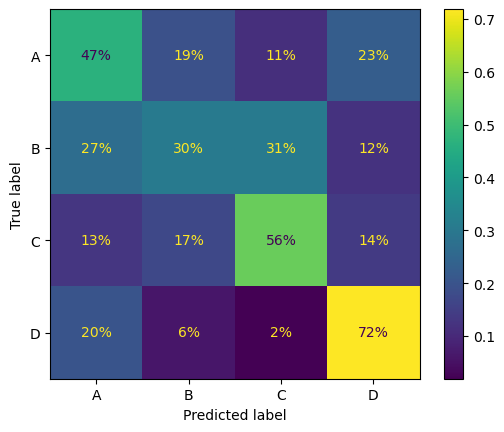

In [36]:
# Shows the normalized version of the same confusion matrix

ConfusionMatrixDisplay.from_predictions(y_train, y_train_predictions, normalize='true', values_format=".0%")
plt.show()

## Predictions

In [38]:
# First, trains the model on full train dataset before making predictions on test data
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_transformation',
                 ColumnTransformer(transformers=[('categorical_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(min_frequency=3,
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Ever_Married',
                                                   'Graduated', 'Profession',
                                                   'Spending_Score']),
                                                 ('numerical_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age', 'Work_Experience',
                                                   'Family_Size'])])),
                ('modeling',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=42))])

In [39]:
# Prepares the test dataset by dropping column "Segmentation"
X_test = test_dataset.drop(["Segmentation"], axis=1)

In [40]:
# Makes predictions on the test dataset
y_test_predictions = model_pipeline.predict(X_test)

# Shows few of the predictions
print(y_test_predictions)

['A' 'B' 'B' ... 'A' 'C' 'D']


In [41]:
# Overrides existing test dataset column 'Segmentation' with the prediction values

test_dataset.Segmentation = y_test_predictions

display(test_dataset)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,A
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,B
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,B
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,D
...,...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6,D
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6,A
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6,A
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4,C


The above test dataset can be saved and submitted for scoring/grading the model performance.